# Topic Modelling from Healthy Tweets

Extract Topics from Health related tweets

## Approach
* Classic case of Unsupervised Learning
    #### Input --> Embeddings --> Cluster (Topics) --> Top N Tweets (Topic Description) --> Keyword Extraction (Sub-Topics)

## Data
* Tweets from 16 different sources
* Around 63k tweets in english

## Preprocess
* Remove non-ascii characters
* Remove URLs
* Extract Hashtags
* Remove RT tags and owner information

## Identify Topics using Hashtags
* Since No information about the tweets is available, use hashtags to get rough idea on Topics of tweets

## Baseline
* Use the Standard LDA to extract topics 
* Used Gensim library

## Clustering (Kmeans + Universal Embeddings)
* Used sentence embeddings to encode the sentences
    * Used Universal Sentence Encoder to get sentence embeddings
* Used Kmeans Algorithm to Identify Tweet groups (topics)
* Find the closest sentence to the Cluster center (Gives Info about the Topic)
* Identify top n closest sentences to the Cluster center 
* Use these top n sentences to Extract Keywords 

## Textrank (Keyword Extraction)
Use Textrank to get weight each keyword from the group of sentences which were identified earlier (closest to the center)

## Learnings
* There are lot of irrelevant tweets which corrupt the Topic group (Discard them for further analysis)
    * Use distance from cluster center to discard irrelevant tweets
    * Also outlier tweets (which do not have many similar tweets based on cosine distance between the sentence embeddings) can be discarded
* Hashtags give good approximation about the topics of tweets

## Improvements
* Universal Embeddings were trained on generic texts, fine-tune them with domain specific texts and tweets like texts
* Use Other Embedding techniques (ElMo vectors, skip thoughts etc..)
* Extend Textrank to consider phrases (ngrams) as candidates
* Model Topics as Seq2Seq problem where input is the tweet text and ouput being topic keywords



# Code

## Import Required Packages
* tensorflow - Universal Sentence Encoders
* sklearn - Kmeans and Distance Metrics
* matplotlib - Plots

In [65]:
import string
import tensorflow as tf
import tensorflow_hub as hub
import os,re,numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, pairwise_distances

## Download Universal Sentence Encoders

In [2]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
embed = hub.Module(module_url)


def get_encodings(sentences):
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        encodings = session.run(embed(sentences))
    return encodings

Instructions for updating:
Colocations handled automatically by placer.


W0406 06:30:07.519669 139746879596288 deprecation.py:323] From /data/docsapp_v1/docs_venv/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


## Download and Process Tweets

In [3]:
path = "Health-Tweets"
all_data = []
for _file in os.listdir(path):
    print(_file)
    with open(path+'/'+_file,'r',encoding='utf-8',errors='ignore') as fin:
#         data = fin.readlines()
        for line in fin:
            try:
                line = line.encode('utf-8').decode('utf-8')
                all_data.append(line)
            except Exception as e:
                print(e)

bbchealth.txt
cbchealth.txt
cnnhealth.txt
everydayhealth.txt
foxnewshealth.txt
gdnhealthcare.txt
goodhealth.txt
KaiserHealthNews.txt
latimeshealth.txt
msnhealthnews.txt
NBChealth.txt
nprhealth.txt
nytimeshealth.txt
reuters_health.txt
usnewshealth.txt
wsjhealth.txt


In [99]:
len(os.listdir(path))

16

In [4]:
tweets = [i.split('|')[-1] for i in all_data]

In [5]:
len(tweets)

63327

In [6]:
tweets[:10]

['Breast cancer risk test devised http://bbc.in/1CimpJF\n',
 'GP workload harming care - BMA poll http://bbc.in/1ChTBRv\n',
 "Short people's 'heart risk greater' http://bbc.in/1ChTANp\n",
 "New approach against HIV 'promising' http://bbc.in/1E6jAjt\n",
 "Coalition 'undermined NHS' - doctors http://bbc.in/1CnLwK7\n",
 'Review of case against NHS manager http://bbc.in/1Ffj6ci\n',
 "VIDEO: 'All day is empty, what am I going to do?' http://bbc.in/1N7wSSz\n",
 "VIDEO: 'Overhaul needed' for end-of-life care http://bbc.in/1CmrRu3\n",
 "Care for dying 'needs overhaul' http://bbc.in/1FdSGrl\n",
 'VIDEO: NHS: Labour and Tory key policies http://bbc.in/1Ci5eqD\n']

## Get Hashtags from tweets

In [ ]:
def get_hashtags(tweet):
    return [i.lower() for i in re.findall("#(\w+)",tweet)]

In [ ]:
hashtags = [get_hashtags(tweet) for tweet in tweets]

In [ ]:
all_hashtags = sum(hashtags,[])

In [ ]:
Counter(all_hashtags).most_common(100)

## Top Topics Extracted from Hashtags

* Health Tips
* Weightloss Ads
* Excercise and Fitness
* Obamacare
* Pharma
* Vaccination
* Healthy Recipies
* Nutrition
* Diet
* Diseases
    * Depression
    * Autism
    * Allergies
    * BreastCancer
    * Alzheimers
    * Meningitis
    * Ebola


## Pre-Processing Tweets 

In [94]:
# clean tweet
def clean_tweet(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. 
    '''
    cleaned_tweet = re.sub("((RT)* @[A-Za-z0-9]+)|([^0-9A-Za-z '\t])|(\w+:\/\/\S+)|(\w+:)", " ", tweet)
    cleaned_tweet = re.sub("\s+"," ",cleaned_tweet).strip()
    return cleaned_tweet


In [95]:
clean_tweet(""" "VIDEO: 'All day is empty, what am I going to do?' http://bbc.in/1N7wSSz\n",""")

"'All day is empty what am I going to do '"

In [9]:
cleaned_tweets = [clean_tweet(i) for i in tweets]

In [10]:
len(tweets),  len(cleaned_tweets)

(63327, 63327)

In [145]:
cleaned_tweets[:10]

['Breast cancer risk test devised',
 'GP workload harming care BMA poll',
 'Short people s heart risk greater',
 'New approach against HIV promising',
 'Coalition undermined NHS doctors',
 'Review of case against NHS manager',
 'All day is empty what am I going to do',
 'Overhaul needed for end of life care',
 'Care for dying needs overhaul',
 'Labour and Tory key policies']

In [146]:
tweets[:10]

['Breast cancer risk test devised http://bbc.in/1CimpJF\n',
 'GP workload harming care - BMA poll http://bbc.in/1ChTBRv\n',
 "Short people's 'heart risk greater' http://bbc.in/1ChTANp\n",
 "New approach against HIV 'promising' http://bbc.in/1E6jAjt\n",
 "Coalition 'undermined NHS' - doctors http://bbc.in/1CnLwK7\n",
 'Review of case against NHS manager http://bbc.in/1Ffj6ci\n',
 "VIDEO: 'All day is empty, what am I going to do?' http://bbc.in/1N7wSSz\n",
 "VIDEO: 'Overhaul needed' for end-of-life care http://bbc.in/1CmrRu3\n",
 "Care for dying 'needs overhaul' http://bbc.in/1FdSGrl\n",
 'VIDEO: NHS: Labour and Tory key policies http://bbc.in/1Ci5eqD\n']

In [13]:
sentences = list(set(cleaned_tweets))

In [14]:
len(cleaned_tweets), len(sentences)

(63327, 59910)

## Encode Tweets using Universal Sentence Encoder

In [15]:
print('Encoding sentences using Universal Sentence Encoder...')
enc_article = get_encodings(sentences)
print('Encoding Done...')

Encoding sentences using Universal Sentence Encoder...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0406 06:31:01.385997 139746879596288 saver.py:1483] Saver not created because there are no variables in the graph to restore


Encoding Done...


In [16]:
from sklearn.manifold import TSNE

In [102]:
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(enc_article[:1000])

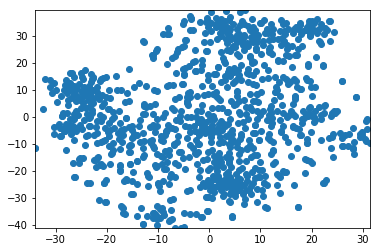

In [103]:
x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()

The plot shows lots of irrelevant tweets masking the Clusters, Discard them

## Find Optimal Number of Clusters using Silloute Analysis

In [29]:
Sum_of_squared_distances = []
K = list(range(5,100,10))
for k in K:
    print(k)
    km = KMeans(n_clusters=k)
    km = km.fit(enc_article)
    Sum_of_squared_distances.append(km.inertia_)

5
15
25
35
45
55
65
75
85
95


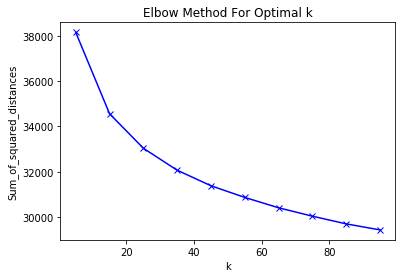

In [30]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## Hierarchical Clustering

In [ ]:
# from scipy.cluster.hierarchy import dendrogram, linkage
# # calculate full dendrogram
# plt.figure(figsize=(25, 10))
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(
#     linkage(enc_article,method='ward'),
#     truncate_mode='lastp',  # show only the last p merged clusters
#     p=12,  # show only the last p merged clusters
#     show_leaf_counts=False,  # otherwise numbers in brackets are counts
#     leaf_rotation=90.,
#     leaf_font_size=12.,
#     show_contracted=True,  # to get a distribution impression in truncated branches
# )
# plt.show()

In [ ]:
# import scipy.cluster.hierarchy as shc

# plt.figure(figsize=(10, 7))  
# plt.title("Customer Dendograms")  
# dend = shc.dendrogram(shc.linkage(enc_article, method='ward'))  

## Kmeans Clustering

In [49]:
# n_clusters = int(np.ceil(len(enc_article)**0.5))
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans = kmeans.fit(enc_article)

## Tweets Closest to CLuster Centers (Proabable Topics)

In [50]:
closest = []
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_,\
                                           enc_article)

In [83]:
for ind,i in enumerate(closest):
    print(ind, sentences[i])
    print()

0 USDA report says pesticide residues in food nothing to fear

1 High Proportion of Health Plan Enrollees Paid Premiums

2 Surgeon Experience Matters in Neck Artery

3 FDA approves Truvada for preventing HIV infection

4 FDA puts partial hold on CytRx cancer drug trials

5 Local Uninsured Programs Face Uncertain Times As Obamacare Ramps Up

6 Burpees are one of the BEST body weight exercise to get in shape Check out these 3 challenging

7 RT A look at the gluten free craze Some foods have few vitamins high sugar And health benefits beyond celiac unproven

8 New Drug Targets Underlying Cause of Cystic

9 Behavior therapy may help prevent depression over vision loss

10 NYC Ebola Patient Declared Free Of Virus Will Be Discharged From Hospital

11 Idea of Healthy Obesity Is Tested

12 IVF Baby Births From Fertility Procedure Hit New High

13 Recipe of the Day Grilled Zucchini Roll Ups With Herbs and Cheese snack recipe

14 Trouble sleeping Let these sleep friendly foods act as your natura

## Probable Topics Extracted from Tweets using Kmeans
1. Updates from USDA
2. 
3. Diseases - HIV
4. Diseases - Cancer
5. ObamaCare
6. Exercise and Fitness
7. Nutrition and Diet
8. Diseases - Cystic
9. Diseases - Depression
10. Diseases - Ebola
<br>...
<br>...
<br>
Health Tips, Weightloss ....

## Explore Topics (Similar tweets closest to Cluster Center)

In [107]:
closest_tweets = pairwise_distances(kmeans.cluster_centers_,enc_article)

### Sample Topic -  Weight Loss (Tweets related to Weightloss grouped by Kmeans)

In [110]:
sample_text= ''
for i in np.argsort(closest_tweets[23])[:20]:
    print(sentences[i])
    sample_text +=sentences[i] +'. '

Losing weight starts with making these 17 fixes to your diet weightloss
4 Ways to Eat More to Weigh Less Great tips from diet weightloss
How I Detoxed Using a 9 Day The Conclusion diet weightloss
If you re on a diet these 10 foods can help you feel fuller longer weightloss
Your New Weight Loss Drive Less NYR diet weightloss
Attention These 25 fattening foods will seriously wreck your weight loss
Want to Lose Weight Here is the 1 Habit You Need to Break dieting weightloss
5 Ways to Keep Exercising During the Holidays diet weight loss
Crank up your metabolism with these 30 fast fat weightloss
These tiny tweaks to your lifestyle could help you lose weight fast
Don t Want to Overeat Stop Multitasking at Mealtime diet weightloss
Feel full tricks to help you lose weight fast
One simple way to boost your weight loss
16 ways to lose weight weightloss
Secrets to Tried and true weight loss advice from diet
Cutting Back On Carbs Not Fat May Lead To More Weight Loss
Trying to Lose Weight These Gad

## Extract Keywords about Topics (Sub-Topics)

In [112]:
from textrank import *
tr4w = TextRank4Keyword() 

In [113]:
def get_keywords(text,num=20):
    tr4w.analyze(text, candidate_pos = ['NOUN', 'PROPN'], window_size=4, lower=True) 
    return tr4w.get_keywords(num) 

In [114]:
get_keywords(sample_text)

weight - 3.434308113117041
diet - 2.9792683055700913
weightloss - 2.5492048403976972
loss - 2.0484737521076806
tips - 1.3346027050991336
overeat - 1.1324789173789174
mealtime - 1.1324789173789174
ways - 1.0844386214314785
kitchen - 0.9042094256933543
foods - 0.8787948754288039
advice - 0.8787948754288039
holidays - 0.8529025677364962
fixes - 0.832908194517123
t - 0.828393666056166
schedule - 0.8172620341298913
new - 0.7322178760393044
drive - 0.7322178760393044
carbs - 0.7322178760393044
fat - 0.7322178760393044
crank - 0.7045283068783068
metabolism - 0.7045283068783068
fattening - 0.7040596800686085


## Baseline 
## LDA using Gensim

## Import Required packages

In [120]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

In [121]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Pre-Process Tweets

In [125]:
def lemmatize_stemming(text):
#     return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    return WordNetLemmatizer().lemmatize(text, pos='v')

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [126]:
processed_tweets = []
for tweet in cleaned_tweets:
    processed_tweets.append(preprocess(tweet))

## Create Gensim Dictionary (word, num_times(word))

In [127]:
dictionary = gensim.corpora.Dictionary(processed_tweets)

In [129]:
processed_tweets[:2]

[['breast', 'cancer', 'risk', 'test', 'devise'],
 ['workload', 'harm', 'care', 'poll']]

In [130]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 breast
1 cancer
2 devise
3 risk
4 test
5 care
6 harm
7 poll
8 workload
9 greater
10 heart


In [131]:
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [133]:
bow_corpus = [dictionary.doc2bow(tweet) for tweet in processed_tweets]

In [135]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 50, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 5)

## Topic Keywords

In [136]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")


Topic: 0 
Words: 0.095*"diet" + 0.085*"best" + 0.068*"share" + 0.067*"loss" + 0.052*"weight" + 0.038*"hear" + 0.029*"wait" + 0.029*"result" + 0.022*"list" + 0.021*"pack"


Topic: 1 
Words: 0.132*"women" + 0.076*"high" + 0.074*"diabetes" + 0.070*"school" + 0.054*"scientists" + 0.040*"group" + 0.032*"type" + 0.031*"drive" + 0.028*"risk" + 0.025*"pregnant"


Topic: 2 
Words: 0.153*"obamacare" + 0.147*"look" + 0.035*"reach" + 0.031*"expect" + 0.024*"pick" + 0.022*"short" + 0.019*"expose" + 0.019*"goals" + 0.019*"secret" + 0.018*"agree"


Topic: 3 
Words: 0.058*"problems" + 0.055*"abortion" + 0.042*"week" + 0.032*"consider" + 0.027*"solve" + 0.027*"couple" + 0.027*"allergy" + 0.025*"options" + 0.023*"piece" + 0.021*"ahead"


Topic: 4 
Words: 0.100*"go" + 0.093*"parent" + 0.066*"kid" + 0.048*"child" + 0.044*"hard" + 0.028*"milk" + 0.028*"travel" + 0.025*"pass" + 0.021*"shift" + 0.019*"progress"


Topic: 5 
Words: 0.096*"think" + 0.066*"read" + 0.049*"support" + 0.043*"weekend" + 0.038*"great

## Sample Weightloss Tweet to Identify Topic

In [137]:
text = "Losing weight starts with making these 17 fixes to your diet weightloss"

In [141]:
# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(text))

lda_model[bow_vector]

[(14, 0.13755393), (24, 0.6174417), (38, 0.12750115)]

## Weightloss Topic

In [143]:
lda_model.print_topic(24, 10) 

'0.135*"year" + 0.120*"lose" + 0.099*"weight" + 0.043*"reason" + 0.035*"pound" + 0.033*"weightloss" + 0.026*"help" + 0.022*"diet" + 0.021*"clean" + 0.021*"bear"'